In [698]:
%reload_ext autoreload
%autoreload 2
from scrape_GR_tools import *
from scrape_explore import *
from friend_groups import *
from modeling import *
#put this in scrape_GR_tools
import pandas as pd

import graphlab as gl

import networkx as nx
import nxpd as nxpd
from IPython.display import display, Image
import community

from datetime import date, datetime
grDateFormat = '%b %d, %Y'

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

from itertools import product

SETTING UP DATA FOR PREDICTION

In [2]:
client = MongoClient("mongodb://35.163.255.3") #bigCruncher

In [3]:
allComms = collectAllComms(client)

Checking database 'goodreads_explore_from_book_tnc'
Database has 0 comms (we now have 0 in total)

Checking database 'goodreads_explore_from_book_ender'
Database has 11 comms (we now have 11 in total)

Checking database 'goodreads_explore_from_book_fault_in_our_stars'
Database has 0 comms (we now have 11 in total)

Checking database 'goodreads_explore_from_book_hedgehog'
Database has 2 comms (we now have 13 in total)

Checking database 'goodreads_explore_from_book_pride_and_prejudice'
Database has 9 comms (we now have 22 in total)

Checking database 'goodreads_explore_from_book_mice_and_men'
Database has 11 comms (we now have 33 in total)

Checking database 'goodreads_explore_from_book_jest'
Database has 19 comms (we now have 52 in total)

Checking database 'goodreads_explore_from_book_swiftly'
Database has 0 comms (we now have 52 in total)

Checking database 'goodreads_explore_from_book_lies'
Database has 0 comms (we now have 52 in total)

Checking database 'goodreads_explore_from_boo

In [779]:
dbFull = client['goodreads_full']

ratingsFull = dbFull['ratings']
friendsFull = dbFull['friends']
booksFull = dbFull['books']

#updateCommsOfRaters2(booksFull, allComms)
#updateCommsOfRaters(ratingsFull, booksFull, allComms)
booksToRaterComms = getCommsOfRaters(ratingsFull, allComms)

In [880]:
glRatings = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 20, 20, False)
outlierDict, glRatingsNoOutliers = removeGlOutliers(glRatings)

In [899]:
'''
glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID")
'''

glRatingsTrain, glRatingsTest = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 20, 20,\
                                                     True, datetime.strptime('Apr 17, 2013', grDateFormat))
'''
glRatingsTrain = glRatingsTrain[glRatingsTrain['comm'].apply(lambda x: outlierDict[x])]
glRatingsTest = glRatingsTest[glRatingsTest['comm'].apply(lambda x: outlierDict[x])]
'''

"\nglRatingsTrain = glRatingsTrain[glRatingsTrain['comm'].apply(lambda x: outlierDict[x])]\nglRatingsTest = glRatingsTest[glRatingsTest['comm'].apply(lambda x: outlierDict[x])]\n"

In [900]:
print glRatingsTrain.shape
print glRatingsTest.shape

(50494, 4)
(16320, 4)


In [984]:
numRatingsByUser = glRatingsTrain.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})['numRatings']
numRatingsByUser = pd.Series(numRatingsByUser)
(numRatingsByUser >= 20).mean()
numRatingsByUser.describe()

count    940.000000
mean      53.717021
std       51.708641
min        1.000000
25%       19.000000
50%       37.000000
75%       75.000000
max      433.000000
dtype: float64

In [986]:
numRatingsByBook = glRatingsTrain.groupby(['bookID'], {'numRatings': gl.aggregate.COUNT('rating')})['numRatings']
numRatingsByBook = pd.Series(numRatingsByBook)
(numRatingsByBook >= 20).mean()
numRatingsByBook.describe()

count    1270.000000
mean       39.759055
std        46.625888
min         1.000000
25%        18.000000
50%        25.000000
75%        42.750000
max       426.000000
dtype: float64

PREDICTION

TRADITIONAL RECOMMENDER

In [903]:
# make sure we train the recommender without community information

glRatingsTrainWithComm = glRatingsTrain.copy()
glRatingsTestWithComm = glRatingsTest.copy()

if 'comm' in glRatingsTrain.column_names():
    glRatingsTrain.remove_column('comm');
if 'comm' in glRatingsTest.column_names():
    glRatingsTest.remove_column('comm');

In [904]:
degreesOfFreedomStats(glRatingsTrain)

50494 observations
940 users
1270 books

A recommender with 0 factor(s) (plus linear terms) would use 4.4% of the degrees of freedom present in the data.
(22.8 observations per model degree of freedom)

A recommender with 1 factor(s) (plus linear terms) would use 8.8% of the degrees of freedom present in the data.
(11.4 observations per model degree of freedom)

A recommender with 2 factor(s) (plus linear terms) would use 13.1% of the degrees of freedom present in the data.
(7.6 observations per model degree of freedom)

A recommender with 3 factor(s) (plus linear terms) would use 17.5% of the degrees of freedom present in the data.
(5.7 observations per model degree of freedom)

A recommender with 4 factor(s) (plus linear terms) would use 21.9% of the degrees of freedom present in the data.
(4.6 observations per model degree of freedom)

A recommender with 5 factor(s) (plus linear terms) would use 26.3% of the degrees of freedom present in the data.
(3.8 observations per model degree 

In [ ]:

models = gl.toolkits.model_parameter_search.grid_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': [2, 4, 8],
                                                      'max_iterations': 2000,
                                                      'regularization': [1e-3, 1e-4, 1e-5],
                                                      'linear_regularization': 1e-4
                                                      })
'''
models = gl.toolkits.model_parameter_search.grid_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': 0,
                                                      'max_iterations': 2000,
                                                      'regularization': 1e-3,
                                                      'linear_regularization': [10**i for i in range(-4,0)]
                                                      })
'''

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-28-2016-00-01-3700000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-28-2016-00-01-3700000' scheduled.


In [64]:
models.get_status()
#models.get_results().sort('validation_rmse')

NameError: name 'models' is not defined

In [905]:
rec_engine_baseline = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=0,
                                                    solver='auto',
                                                    max_iterations=50,
                                                    regularization = 1e-3,
                                                    linear_regularization = 1e-14
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 50494 observations with 940 users and 1270 items.

Data prepared in: 0.127486s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 0        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-14    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 50494 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.45817           | 0.876573                                 |

| 1       | 0.729087          | 0.829149                                 |

| 2       | 0.364543          | 0.741573                                 |

| 3       | 0.182272          | 0.675077                                 |

| 4       | 0.0911358         | 0.66554                                  |

| 5       | 0.0455679         | 0.687044                                 |

| 6       | 0.022784          | 0.718905                                 |

| 7       | 0.011392          | 0.762011                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0911358         | 0.66554                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 69us         | 1.02046           | 1.01018               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 531.811ms    | 0.971929          | 0.985862              | 0.0911358   |

| 2       | 1.04s        | 0.830066          | 0.91108               | 0.016269    |

| 3       | 1.54s        | 0.788817          | 0.888154              | 0.00893171  |

| 4       | 2.04s        | 0.77871           | 0.882445              | 0.00615556  |

| 5       | 2.49s        | 0.774116          | 0.879839              | 0.00469597  |

| 6       | 2.98s        | 0.771271          | 0.87822               | 0.00379589  |

| 10      | 4.93s        | 0.766197          | 0.875327              | 0.0021486   |

| 11      | 5.42s        | 0.765512          | 0.874936              | 0.00193831  |

| 15      | 7.42s        | 0.763778          | 0.873944              | 0.00139297  |

| 20      | 9.82s        | 0.762592          | 0.873265              | 0.00103055  |

| 25      | 12.26s       | 0.761908          | 0.872874              | 0.000817776 |

| 30      | 14.69s       | 0.761448          | 0.87261               | 0.000677829 |

| 35      | 17.12s       | 0.761117          | 0.87242               | 0.000578781 |

| 40      | 19.51s       | 0.760866          | 0.872277              | 0.00050499  |

| 45      | 21.99s       | 0.760674          | 0.872166              | 0.000447886 |

| 50      | 24.42s       | 0.760515          | 0.872075              | 0.000402386 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.759312

Final training RMSE: 0.871385

In [907]:
rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

0.9227421788334164

In [979]:
rec_engine = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=4,
                                                    solver='auto',
                                                    max_iterations=50,
                                                    regularization = 1e-3,
                                                    linear_regularization = 1e-14
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 50494 observations with 940 users and 1270 items.

Data prepared in: 0.124978s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-14    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 50494 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.45817           | No Decrease (1.44983 >= 1.0252)          |

| 1       | 0.364543          | No Decrease (1.94798 >= 1.0252)          |

| 2       | 0.0911358         | 0.667426                                 |

| 3       | 0.0455679         | 0.690198                                 |

| 4       | 0.022784          | 0.723201                                 |

| 5       | 0.011392          | 0.766074                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0911358         | 0.667426                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 1.02047           | 1.01018               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 481.923ms    | DIVERGED          | DIVERGED              | 0.0911358   |

| RESET   | 488.824ms    | 1.02045           | 1.01018               |             |

| 1       | 1.00s        | DIVERGED          | DIVERGED              | 0.0455679   |

| RESET   | 1.01s        | 1.02048           | 1.01019               |             |

| 1       | 1.49s        | 0.876935          | 0.936447              | 0.022784    |

| 2       | 1.98s        | 0.803556          | 0.896413              | 0.010595    |

| 3       | 2.47s        | 0.787177          | 0.88723               | 0.00690233  |

| 4       | 2.96s        | 0.780239          | 0.883312              | 0.00511843  |

| 5       | 3.46s        | 0.776135          | 0.880985              | 0.00406725  |

| 6       | 3.96s        | 0.773537          | 0.879509              | 0.00337427  |

| 8       | 4.92s        | 0.770148          | 0.877581              | 0.00251668  |

| 11      | 6.37s        | 0.767508          | 0.876075              | 0.00182206  |

| 13      | 7.36s        | 0.766446          | 0.875469              | 0.00153889  |

| 18      | 9.77s        | 0.764694          | 0.874468              | 0.00110829  |

| 23      | 12.21s       | 0.763699          | 0.873899              | 0.000865982 |

| 28      | 14.64s       | 0.763032          | 0.873517              | 0.000710617 |

| 33      | 17.12s       | 0.762555          | 0.873244              | 0.000602519 |

| 38      | 19.64s       | 0.762201          | 0.873041              | 0.000522966 |

| 43      | 22.09s       | 0.76193           | 0.872886              | 0.000461971 |

| 48      | 24.53s       | 0.761707          | 0.872758              | 0.000413717 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.760432

Final training RMSE: 0.872028

In [980]:
print rec_engine.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']
print rec_engine.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

0.915790362925
-0.00695181590812


In [ ]:
0.915861596669
-0.00688058216447
In [ ]:


In [987]:
rec_engine.get('coefficients')['userID']

userID,linear_terms,factors
13389,0.439645767212,"[3.71985976244e-07,-1.53922428581e-06, ..."
147129,0.0251087341458,"[5.18471345856e-08,-9.70982341642e-07, ..."
82625,0.250813126564,"[1.79769173769e-07,8.1109550365e-07, ..."
12251,0.669575691223,"[-4.46370364671e-07,2.12948005895e-08, ..."
160216,0.0273415129632,"[1.77737615559e-06,6.79412232785e-06, ..."
1,0.368500977755,"[-9.11547249416e-06,2.85024889308e-05, ..."
546,0.483818948269,"[-3.97447911382e-06,-2.04266943911e-05, ..."
609,-0.213202491403,"[1.00173986084e-06,1.15126576929e-05, ..."
657,0.253477931023,"[6.59686492099e-08,-2.47705855827e-07, ..."
25943,-0.453521102667,"[-3.50872778654e-06,-3.1284896977e-05, ..."


SOCIAL MODELS

In [929]:
glCommMeansTrain, glCommBookMeansTrain, commMeansTrain, commBookMeansTrain = \
makeSocialModelInputs(glRatingsTrainWithComm)

In [1075]:
meanWeights = np.linspace(0,0.6,100)

#SIMPLE PREDICTION FROM COMM MEANS
'''
rmsesSimple = []

for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, True, weight)[1])
'''
#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, False, weight)[1])
    
#FACTORIZING COMM MEANS
'''
rmsesFac = []
for weight in meanWeights:
    rmsesFac.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, rec_engine_8, rec_engine_8 \
                          commMeans_rec_engine_baseline, True, False, True, weight)[1])
'''

'\nrmsesFac = []\nfor weight in meanWeights:\n    rmsesFac.append(                mixedPred(glRatingsTestWithComm,                           commMeansTrain, commBookMeansTrain, rec_engine_8, rec_engine_8                           commMeans_rec_engine_baseline, True, False, True, weight)[1])\n'

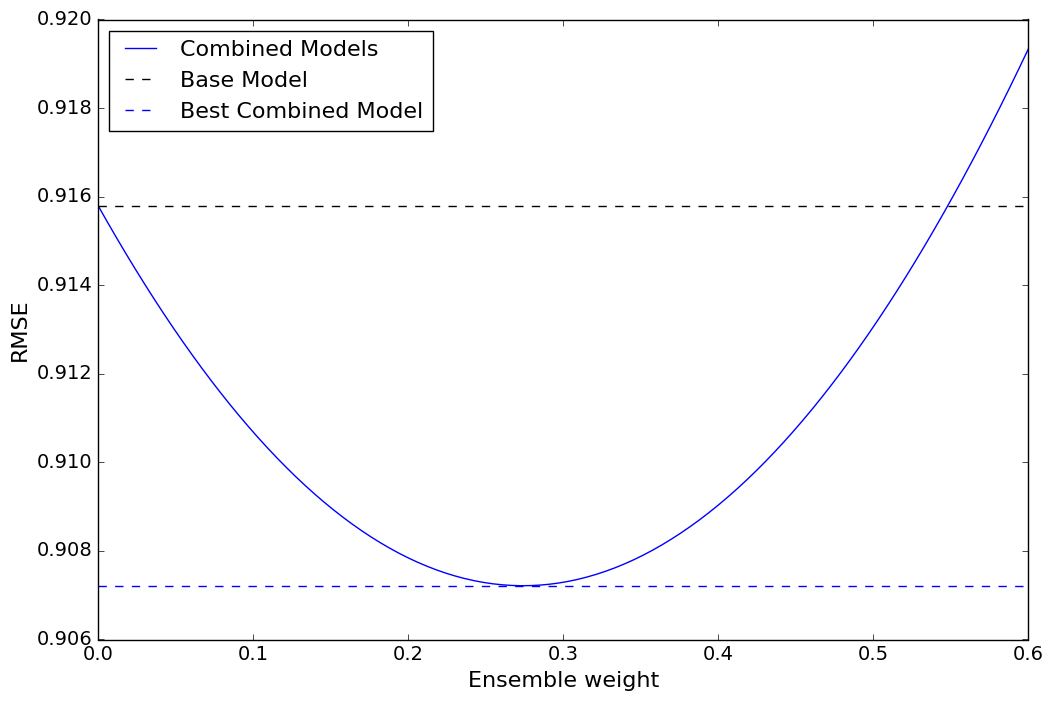

In [1083]:
plt.figure(figsize=(12,8))
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-', label='Combined Models');
plt.axhline(rmsesSimple[0],color='k',linestyle='--', label='Base Model');
plt.axhline(rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)],linestyle='--',label='Best Combined Model')
plt.xlabel('Ensemble weight',fontsize=16)
plt.ylabel('RMSE',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best',fontsize=16);

In [1048]:
print meanWeights[np.argmin(rmsesSimple)]
print rmsesSimple[np.argmin(rmsesSimple)]

print ''

print meanWeights[np.argmin(rmsesSimpleNoBookMeans)]
print rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)]

0.241379310345
0.907855277979

0.275862068966
0.907214854486


USING COMMUNITY MEANS OF RECOMMENDER PREDICTIONS

In [912]:
test = [(bookID, userID) for bookID, userID in product(glRatings['bookID'].unique(), glRatings['userID'].unique())]

In [913]:
#test
testDict = {}
npTest = np.array(test)
testDict['bookID'] = npTest[:,0]
testDict['userID'] = npTest[:,1]
sfTest = gl.SFrame(testDict)

In [914]:
allPreds = rec_engine.predict(sfTest)

In [915]:
sfTest.add_column(allPreds, 'preds')

bookID,userID,preds
1162543,32119,3.03590595132
1162543,271433,3.03590595132
1162543,135475,3.03590595132
1162543,5247,3.03590595132
1162543,14871,3.03590595132
1162543,247244,3.03590595132
1162543,147129,3.03590595132
1162543,9169100,3.03590595132
1162543,94664,3.03590595132
1162543,24243723,3.03590595132


In [916]:
commDict = {uID: i for i, comm in enumerate(allComms) for uID in comm}

sfTest.add_column(sfTest['userID'].apply(lambda x: commDict[int(x)]), 'comm')

bookID,userID,preds,comm
1162543,32119,3.03590595132,8
1162543,271433,3.03590595132,55
1162543,135475,3.03590595132,41
1162543,5247,3.03590595132,21
1162543,14871,3.03590595132,22
1162543,247244,3.03590595132,17
1162543,147129,3.03590595132,46
1162543,9169100,3.03590595132,68
1162543,94664,3.03590595132,30
1162543,24243723,3.03590595132,48


In [917]:
sfTest[['bookID', 'preds', 'comm']].groupby(['bookID', 'comm'], {'avgPreds': gl.aggregate.AVG('preds')})

bookID,comm,avgPreds
10569,55,4.00803316539
11278959,59,3.47377260929
28381,4,3.93346711403
17336704,24,3.63113679891
485894,49,3.94561145609
7937843,46,3.83564817315
29209,2,3.78459570525
420282,2,4.0451092661
216363,4,3.92858416741
11590,30,3.48331939583


In [918]:
factorCommBookMeansTrain = {}
for row in sfTest:
    factorCommBookMeansTrain[(row['bookID'], row['comm'])] = row['preds']


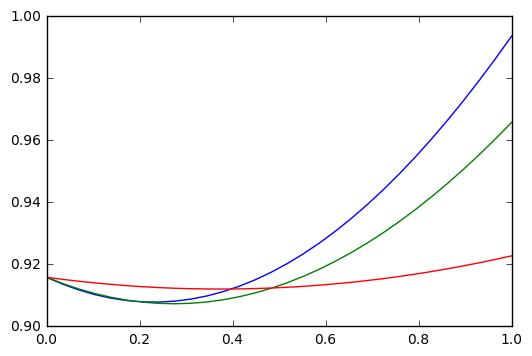

In [919]:
meanWeights = np.linspace(0,1,30)

#SIMPLE PREDICTION FROM COMM MEANS
rmsesSimple = []

for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, True, weight)[1])

#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, False, weight)[1])
    
#FACTORIZING COMM MEANS

rmsesFac = []
for weight in meanWeights:
    rmsesFac.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine, \
                          True, False, True, weight)[1])

plt.plot(meanWeights, rmsesSimple, '-');
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-');
plt.plot(meanWeights, rmsesFac, '-')

In [826]:
print meanWeights[np.argmin(rmsesSimple)]
print rmsesSimple[np.argmin(rmsesSimple)]

0.137931034483
0.887995003275


FACTORIZATION RECOMMENDER FOR RAW (COMMUNITY-BOOK-RATING) DATA

In [930]:
#glCommTrain = glRatingsTrainWithComm.copy()['bookID', 'comm', 'rating']
#glCommTest = glRatingsTestWithComm.copy()['bookID', 'comm', 'rating']
glCommTrain = glCommBookMeansTrain.copy()

glCommTrain['rating'] = glCommTrain['meanBookRatingByComm']
glCommTrain.remove_column('meanBookRatingByComm')

bookID,comm,rating
485894,49,3.0
7937843,46,2.5
5043,24,3.0
4407,30,3.0
6334,49,3.66666666667
2696,49,4.0
22328,3,5.0
2429135,46,3.25
2612,70,3.0
4953,23,3.5


In [931]:
glCommMeansTest, glCommBookMeansTest, commMeansTest, commBookMeansTest = \
makeSocialModelInputs(glRatingsTestWithComm)

glCommTest = glCommBookMeansTest.copy()
glCommTest['rating'] = glCommTest['meanBookRatingByComm']
glCommTest.remove_column('meanBookRatingByComm')

bookID,comm,rating
1971304,49,5.0
2429135,46,1.0
11,4,4.0
12220,55,5.0
249747,69,4.0
8520610,46,5.0
13335037,13,5.0
13256917,2,3.5
9361589,49,4.0
21,49,5.0


In [932]:
degreesOfFreedomStats(glCommTrain)

22220 observations
72 users
1270 books

A recommender with 0 factor(s) (plus linear terms) would use 6.0% of the degrees of freedom present in the data.
(16.6 observations per model degree of freedom)

A recommender with 1 factor(s) (plus linear terms) would use 12.1% of the degrees of freedom present in the data.
(8.3 observations per model degree of freedom)

A recommender with 2 factor(s) (plus linear terms) would use 18.1% of the degrees of freedom present in the data.
(5.5 observations per model degree of freedom)

A recommender with 3 factor(s) (plus linear terms) would use 24.2% of the degrees of freedom present in the data.
(4.1 observations per model degree of freedom)

A recommender with 4 factor(s) (plus linear terms) would use 30.2% of the degrees of freedom present in the data.
(3.3 observations per model degree of freedom)

A recommender with 5 factor(s) (plus linear terms) would use 36.2% of the degrees of freedom present in the data.
(2.8 observations per model degree o

In [939]:
rec_engine_comm_baseline = gl.factorization_recommender.create(   observation_data=glCommTrain, 
                                                    user_id="comm", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=0,
                                                    solver='auto',
                                                    max_iterations=50,
                                                    regularization = 1e-2,
                                                    linear_regularization = 1e-4
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 22220 observations with 72 users and 1270 items.

Data prepared in: 0.124427s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 0        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 22220 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.331056          | No Decrease (0.79202 >= 0.777007)        |

| 1       | 0.0827641         | 0.603607                                 |

| 2       | 0.041382          | 0.608211                                 |

| 3       | 0.020691          | 0.630366                                 |

| 4       | 0.0103455         | 0.656499                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0827641         | 0.603607                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 99us         | 0.76868           | 0.876744              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 660.22ms     | 0.784455          | 0.876689              | 0.0827641   |

| 2       | 1.32s        | 0.663837          | 0.805691              | 0.00426835  |

| 3       | 1.99s        | 0.642378          | 0.792447              | 0.00219066  |

| 4       | 2.65s        | 0.63687           | 0.789062              | 0.0014685   |

| 5       | 3.30s        | 0.634114          | 0.787374              | 0.00110721  |

| 6       | 3.95s        | 0.63222           | 0.786212              | 0.000888598 |

| 10      | 6.55s        | 0.628514          | 0.78394               | 0.000496483 |

| 11      | 7.23s        | 0.627972          | 0.783607              | 0.000447153 |

| 15      | 9.89s        | 0.626452          | 0.782673              | 0.000319983 |

| 20      | 13.19s       | 0.625307          | 0.781968              | 0.000236062 |

| 25      | 16.51s       | 0.624551          | 0.781502              | 0.000187015 |

| 30      | 19.80s       | 0.624005          | 0.781164              | 0.000154843 |

| 35      | 23.07s       | 0.623586          | 0.780904              | 0.000132115 |

| 40      | 26.39s       | 0.623249          | 0.780695              | 0.000115205 |

| 45      | 29.77s       | 0.622973          | 0.780523              | 0.000102133 |

| 50      | 33.09s       | 0.622739          | 0.780377              | 9.17249e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.622501

Final training RMSE: 0.780225

In [940]:
rec_engine_comm_baseline.evaluate_rmse(glCommTest, target='rating')['rmse_overall']

0.8492236017877337

In [945]:
rec_engine_comm = gl.factorization_recommender.create(   observation_data=glCommTrain, 
                                                    user_id="comm", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=4,
                                                    solver='auto',
                                                    max_iterations=50,
                                                    regularization = 1e-3,
                                                    linear_regularization = 1e-4
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 22220 observations with 72 users and 1270 items.

Data prepared in: 0.141546s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 22220 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 3.31056           | 0.707354                                 |

| 1       | 1.65528           | 0.754305                                 |

| 2       | 0.827641          | Not Viable                               |

| 3       | 0.20691           | No Decrease (1.08416 >= 0.777007)        |

+---------+-------------------+------------------------------------------+

| Final   | 3.31056           | 0.707354                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 0.76868           | 0.876744              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 461.388ms    | DIVERGED          | DIVERGED              | 3.31056     |

| RESET   | 512.836ms    | 0.768676          | 0.876742              |             |

| 1       | 1.22s        | DIVERGED          | DIVERGED              | 1.65528     |

| RESET   | 1.26s        | 0.768676          | 0.876742              |             |

| 1       | 1.98s        | DIVERGED          | DIVERGED              | 0.827641    |

| RESET   | 2.03s        | 0.768676          | 0.876742              |             |

| 1       | 2.71s        | DIVERGED          | DIVERGED              | 0.41382     |

| RESET   | 2.76s        | 0.768673          | 0.87674               |             |

| 1       | 3.43s        | DIVERGED          | DIVERGED              | 0.20691     |

| RESET   | 3.44s        | 0.768678          | 0.876743              |             |

| 1       | 4.17s        | DIVERGED          | DIVERGED              | 0.103455    |

| RESET   | 4.21s        | 0.76868           | 0.876744              |             |

| 1       | 4.86s        | 0.740041          | 0.853386              | 0.0517275   |

| 2       | 5.45s        | 0.666843          | 0.808914              | 0.0240662   |

| 3       | 6.10s        | 0.648065          | 0.79693               | 0.0156808   |

| 4       | 6.76s        | 0.640544          | 0.791955              | 0.011629    |

| 5       | 7.42s        | 0.635988          | 0.788959              | 0.00924111  |

| 6       | 8.06s        | 0.63309           | 0.786992              | 0.00766683  |

| 9       | 10.00s       | 0.627889          | 0.783522              | 0.00507377  |

| 11      | 11.29s       | 0.625847          | 0.782141              | 0.00414024  |

| 14      | 13.39s       | 0.624321          | 0.781089              | 0.00324473  |

| 19      | 16.75s       | 0.622531          | 0.779837              | 0.00238497  |

| 24      | 20.02s       | 0.621532          | 0.779142              | 0.0018854   |

| 29      | 23.35s       | 0.620829          | 0.778641              | 0.00155887  |

| 34      | 26.65s       | 0.620275          | 0.778248              | 0.00132874  |

| 39      | 29.89s       | 0.619893          | 0.77797               | 0.00113247  |

| 44      | 33.18s       | 0.619605          | 0.77776               | 0.000998562 |

| 49      | 36.54s       | 0.619406          | 0.777608              | 0.000898844 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 0.617394

Final training RMSE: 0.776313

In [946]:
print rec_engine_comm.evaluate_rmse(glCommTest, target='rating')['rmse_overall']
print rec_engine_comm.evaluate_rmse(glCommTest, target='rating')['rmse_overall'] - rec_engine_comm_baseline.evaluate_rmse(glCommTest, target='rating')['rmse_overall']

0.84850909904
-0.00071450274821


In [ ]:
0.848510407994
-0.000713193794181
In [ ]:
In [ ]:
In [ ]:


In [947]:
rec_engine_comm.get('coefficients')['comm']

comm,linear_terms,factors
49,-0.0485175698996,"[0.00232555577531,0.00428900169209, ..."
46,-0.0348515696824,"[0.00304393609986,0.00289199361578, ..."
24,0.318906158209,"[0.000162804426509,0.000785160227679, ..."
30,0.135711625218,"[-5.40788641956e-05,0.00510933995247, ..."
3,0.0516358315945,"[-9.04402259039e-05,0.000493495434057, ..."
70,-0.257359296083,"[-0.00256620999426,0.00144182541408, ..."
23,-0.284745752811,"[0.000749856524635,0.000388702406781, ..."
59,0.31371113658,"[0.000384650717024,-0.000852791592479, ..."
60,-0.284195005894,"[0.00193695141934,0.000471268198453, ..."
71,-0.176614835858,"[-0.000641892198473,0.00163679639809, ..."


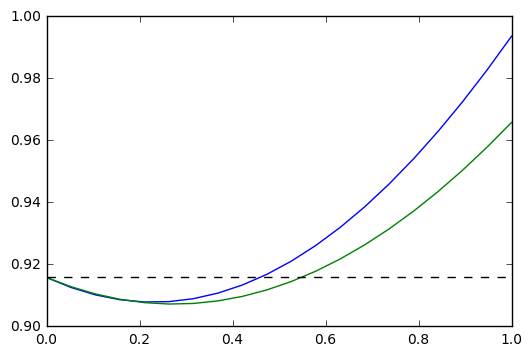

In [1009]:
meanWeights = np.linspace(0,1,20)

#SIMPLE PREDICTION FROM COMM MEANS

rmsesSimple = []
for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, True, weight)[1])

#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, False, weight)[1])
                          

#FACTORIZATION RECOMMENDER FOR RAW (COMMUNITY-BOOK-RATING) DATA
rmsesSocialRec = []

for weight in meanWeights:
    rmsesSocialRec.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, True, False, weight)[1])


plt.plot(meanWeights, rmsesSimple, '-');
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-');
#plt.plot(meanWeights, rmsesSocialRec, '-');


In [765]:

models = gl.toolkits.model_parameter_search.grid_search.create((glCommTrain, glCommTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'comm',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': [8, 32],
                                                      'max_iterations': 1000,
                                                      'regularization': [1e-2, 1e-3, 1e-4, 1e-7],
                                                      'linear_regularization': 1e-4
                                                      },
                                                      perform_trial_run=False)
                                                      

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-28-2016-20-38-1500000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-28-2016-20-38-1500000' scheduled.


In [949]:
models.get_status()
#models.get_results(wait=False).sort('validation_rmse')

{'Canceled': 0, 'Completed': 8, 'Failed': 0, 'Pending': 0, 'Running': 0}

In [989]:
print meanWeights[np.argmin(rmsesSimple)]
print rmsesSimple[np.argmin(rmsesSimple)]

print ''

print meanWeights[np.argmin(rmsesSimpleNoBookMeans)]
print rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)]

print ''


print meanWeights[np.argmin(rmsesSocialRec)]
print rmsesSocialRec[np.argmin(rmsesSocialRec)]

0.210526315789
0.907890443148

0.263157894737
0.907227957204

0.315789473684
0.910720455053


In [990]:
bestWeightComm = meanWeights[np.argmin(rmsesSimpleNoBookMeans)]

predsComm = mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, False, False, bestWeightComm)[0]

predsBase = mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, False, False, 0)[0]

In [1002]:
signTestFrame = glRatingsTestWithComm[['bookID','userID','comm','rating']].copy()
signTestFrame.add_column(gl.SArray(predsComm), 'predsComm')
signTestFrame.add_column(gl.SArray(predsBase), 'predsBase')

bookID,userID,comm,rating,predsComm,predsBase
6194,12436,72,5,4.05259808782,4.06019743686
13586707,12436,72,5,3.8606226668,3.79965936547
7331435,12436,72,5,3.71201353679,3.59797554618
18143977,12436,72,4,3.8606226668,3.79965936547
22034,1,31,5,4.3160943172,4.53024527079
4948,1,31,5,4.48917493162,4.76514039036
22318578,1,31,5,4.04929489689,4.16816034322
13526165,1,31,4,4.10272208422,4.24066866888
231850,1,31,5,4.42062762133,4.67211189782
31196,1,31,5,4.46873210819,4.73739655856


In [1003]:
errsBase = np.abs(np.array(signTestFrame['rating'] - signTestFrame['predsBase'])**2)
errsBase

errsComm = np.abs(np.array(signTestFrame['rating'] - signTestFrame['predsComm'])**2)
(errsComm < errsBase).mean()

0.50594362745098043

In [1004]:
signTestFrame.add_column(gl.SArray(errsComm), 'errsComm')
signTestFrame.add_column(gl.SArray(errsBase), 'errsBase')

bookID,userID,comm,rating,predsComm,predsBase,errsComm,errsBase
6194,12436,72,5,4.05259808782,4.06019743686,0.897570383195,0.883228857679
13586707,12436,72,5,3.8606226668,3.79965936547,1.29818070742,1.44081763891
7331435,12436,72,5,3.71201353679,3.59797554618,1.65890912941,1.96567256912
18143977,12436,72,4,3.8606226668,3.79965936547,0.0194260410108,0.0401363698442
22034,1,31,5,4.3160943172,4.53024527079,0.46772698296,0.220669505615
4948,1,31,5,4.48917493162,4.76514039036,0.260942250482,0.0551590362411
22318578,1,31,5,4.04929489689,4.16816034322,0.903840193075,0.691957214586
13526165,1,31,4,4.10272208422,4.24066866888,0.0105518265866,0.0579214081822
231850,1,31,5,4.42062762133,4.67211189782,0.335672353168,0.107510607554
31196,1,31,5,4.46873210819,4.73739655856,0.282245572864,0.0689605674552


In [1008]:
signTestFrame.groupby(['rating'], {'errsCommAvg': gl.aggregate.AVG('errsComm'),\
                                  'errsBaseAvg': gl.aggregate.AVG('errsBase')}).sort('rating')

rating,errsBaseAvg,errsCommAvg
1,5.90448534451,6.15340499184
2,2.6688149994,2.67606710604
3,0.655697848018,0.582972461962
4,0.169955042012,0.117052225647
5,1.18143082173,1.25054546585


In [993]:
roundedPredsBase = np.round(predsBase)
roundedPredsComm = np.round(predsComm)

In [994]:
(roundedPredsBase == signTestFrame['rating']).mean()

0.41200980392156861

In [995]:
(roundedPredsComm == signTestFrame['rating']).mean()

0.41409313725490199

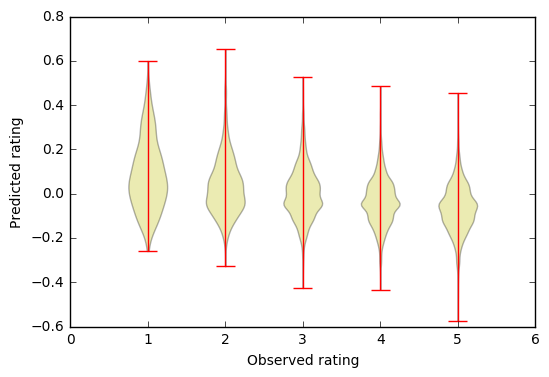

In [998]:
preds_by_rating = []
rating_cats = range(1,6)

for rating in rating_cats:
    preds_by_rating.append(list(predsComm[np.array(glRatingsTest['rating']) == rating]\
                          -predsBase[np.array(glRatingsTest['rating']) == rating]))

plt.violinplot(preds_by_rating, positions=rating_cats);
plt.xlabel('Observed rating');
plt.ylabel('Predicted rating');
#for rating in rating_cats:
#    plt.axhline(rating,linestyle='--',linewidth=1,alpha=0.5)

In [999]:
for i, category in enumerate(preds_by_rating):
    print (i+1, np.median(category))

(1, 0.058961325610539461)
(2, 0.019585672106249952)
(3, -0.0023628270171291987)
(4, -0.039621774063719251)
(5, -0.062194621033736741)


3.7996593654691644

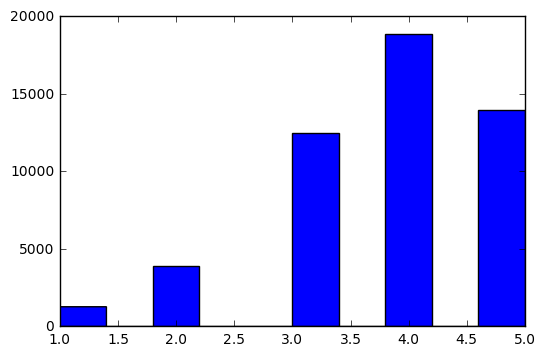

In [1012]:
plt.hist(glRatingsTrain['rating'])
(glRatingsTrain['rating']).mean()

In [963]:
coef_dict = rec_engine.get('coefficients')

In [964]:
coef_dict['userID']

userID,linear_terms,factors
13389,0.449082821608,"[-2.9401418189e-08,-2.47457433034e-06, ..."
147129,0.018716853112,"[6.31890827663e-07,-1.23543497921e-06, ..."
82625,0.256159394979,"[1.29775025925e-06,1.10020755528e-06, ..."
12251,0.671747028828,"[-1.14628380743e-06,-3.97139643837e-07, ..."
160216,0.0298878327012,"[5.05336538481e-06,7.61476530897e-06, ..."
1,0.368342787027,"[-3.67200627807e-05,5.10490754095e-05, ..."
546,0.484111756086,"[-2.40624467551e-06,-3.51996568497e-05, ..."
609,-0.215856999159,"[-2.25407035259e-07,8.75285149959e-06, ..."
657,0.242997214198,"[3.48835055775e-06,1.58360251135e-06, ..."
25943,-0.445351481438,"[1.295065249e-05,-2.90351563308e-05, ..."


In [881]:
s = set(glRatings['bookID'].unique())
numCommsByBook = {k: len(v) for k, v in booksToRaterComms.items() if str(k) in s}

In [882]:
[(k, v) for k, v in numCommsByBook.items() if v == 40]

[(6310, 40),
 (49041, 40),
 (7445, 40),
 (6514, 40),
 (4473, 40),
 (37415, 40),
 (62291, 40),
 (11275, 40),
 (7588, 40),
 (1622, 40)]

In [892]:
for bID in [k for k, v in numCommsByBook.items() if v  == 50]:
    print bID
    print bookTitle(bID)

2429135
(u'The Girl with the Dragon Tattoo\n      \n          (Millennium #1)', 1766752)
48855
(u'The Diary of a Young Girl', 1900271)
168668
(u'Catch-22\n      \n          (Catch-22 #1)', 540094)
13496
(u'A Game of Thrones\n      \n          (A Song of Ice and Fire #1)', 1300530)
41865
(u'Twilight\n      \n          (Twilight  #1)', 3635695)
43641
(u'Water for Elephants', 1044043)
3985
(u'The Amazing Adventures of Kavalier & Clay', 147815)


In [894]:
testBID = 2429135

commIndices = []
allCommBookRatings = []
numRaters = []
meanRatings = []
earliestTimes = []

uIDsInGL = set(glRatings['userID'].unique())

for commIndex in booksToRaterComms[testBID]:
    commRatings = ratingsFull.find({'userID': {'$in': list(set(allComms[commIndex]) & uIDsInGL)}})
    commBookRatings = [(r['ratings'][str(testBID)][0], \
                        datetime.strptime(r['ratings'][str(testBID)][2], grDateFormat), \
                        r['userID'])\
                       for r in commRatings if str(testBID) in r['ratings'].keys()]
    allCommBookRatings.append(commBookRatings)
    
    commIndices.append(commIndex)
    numRaters.append(len(commBookRatings))
    meanRatings.append(np.mean(np.array(commBookRatings)[:,0]))
    earliestTimes.append(min(r[1] for r in commBookRatings))

timeOrder = np.argsort(earliestTimes)

numRatersCumSum = 0
for i in timeOrder:
    numRatersCumSum += numRaters[i]
    if numRaters[i] > 3:
        print 'Community %d' % commIndices[i]
        print '%d raters' % numRaters[i]
        print '%.1f mean rating' % meanRatings[i]
        print 'Earliest rating on %s' % datetime.strftime(earliestTimes[i], grDateFormat)
        print '\nTotal raters thus far: %d\n' % numRatersCumSum

Community 46
5 raters
2.8 mean rating
Earliest rating on Sep 25, 2008

Total raters thus far: 5

Community 10
14 raters
3.4 mean rating
Earliest rating on Nov 17, 2008

Total raters thus far: 22

Community 70
4 raters
4.0 mean rating
Earliest rating on Jan 23, 2009

Total raters thus far: 26

Community 65
12 raters
3.7 mean rating
Earliest rating on Apr 11, 2009

Total raters thus far: 41

Community 21
7 raters
3.4 mean rating
Earliest rating on Jul 15, 2009

Total raters thus far: 50

Community 33
8 raters
3.0 mean rating
Earliest rating on Aug 05, 2009

Total raters thus far: 58

Community 23
6 raters
3.2 mean rating
Earliest rating on Aug 05, 2009

Total raters thus far: 64

Community 49
9 raters
3.6 mean rating
Earliest rating on Aug 05, 2009

Total raters thus far: 73

Community 68
13 raters
3.7 mean rating
Earliest rating on Aug 28, 2009

Total raters thus far: 86

Community 17
4 raters
2.5 mean rating
Earliest rating on Sep 23, 2009

Total raters thus far: 90

Community 67
4 rat

In [103]:
relevantGLratings = glRatings[glRatings.apply(lambda x: x['comm'] == 48 and x['bookID'] == str(testBID))]
relevantGLratings.print_rows(num_rows=42)

+--------+------+--------+----------+
| bookID | comm | rating |  userID  |
+--------+------+--------+----------+
| 11275  |  48  |   4    | 5455905  |
| 11275  |  48  |   4    | 8943786  |
| 11275  |  48  |   3    | 19569261 |
| 11275  |  48  |   4    | 8864511  |
| 11275  |  48  |   4    | 23434392 |
| 11275  |  48  |   5    | 9069989  |
| 11275  |  48  |   5    | 48801419 |
| 11275  |  48  |   4    | 8068801  |
| 11275  |  48  |   4    | 7551020  |
| 11275  |  48  |   5    | 2392247  |
| 11275  |  48  |   4    | 6512932  |
| 11275  |  48  |   3    | 5011787  |
| 11275  |  48  |   4    | 5724539  |
| 11275  |  48  |   5    | 40547054 |
| 11275  |  48  |   1    | 9136579  |
| 11275  |  48  |   5    | 20931024 |
| 11275  |  48  |   4    | 8481252  |
| 11275  |  48  |   5    | 25218011 |
| 11275  |  48  |   4    | 6308393  |
| 11275  |  48  |   5    | 20187777 |
| 11275  |  48  |   5    | 43756219 |
| 11275  |  48  |   3    | 26363295 |
| 11275  |  48  |   4    | 7756517  |
| 11275  |  

In [124]:
relevantGLratings = signTestFrame[signTestFrame.apply(lambda x: x['comm'] == 48 and x['bookID'] == str(testBID))]
relevantGLratings.add_column(gl.SArray(\
                             np.abs(np.array(relevantGLratings['rating'] - relevantGLratings['predsBase']))), \
                             'errsBase')
relevantGLratings.add_column(gl.SArray(\
                             np.abs(np.array(relevantGLratings['rating'] - relevantGLratings['predsComm']))), \
                             'errsComm')

#relevantGLratings.print_rows(num_rows=42, num_columns=8)
print relevantGLratings['errsBase'].mean()
print relevantGLratings['errsComm'].mean()

0.607146395116
0.592260112867


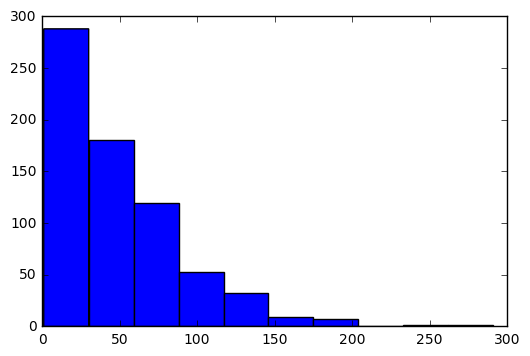

In [564]:
numRatingsByUser = glRatingsTrain.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})
plt.hist(numRatingsByUser['numRatings']);

In [601]:
pdRatingsTrain = glRatingsTrainWithComm.to_dataframe()
pdRatingsTest = glRatingsTestWithComm.to_dataframe()

In [606]:
numRatingsByUserDict = defaultdict(int, {r['userID']: r['numRatings'] for r in numRatingsByUser})

In [607]:
pdRatingsTest['numRatingsByUser'] = pdRatingsTest['userID'].apply(lambda x: numRatingsByUserDict[x])

In [608]:
pdRatingsTest['numRatingsByUser'].describe()

count    15168.000000
mean        42.659480
std         58.317078
min          0.000000
25%          0.000000
50%          8.000000
75%         73.000000
max        291.000000
Name: numRatingsByUser, dtype: float64

In [631]:
numRatingsCutoff = 50
pdManyRatings = pdRatingsTest[(pdRatingsTest['numRatingsByUser'] <= numRatingsCutoff) & (pdRatingsTest['numRatingsByUser'] > 0)]
print ((pdRatingsTest['numRatingsByUser'] <= numRatingsCutoff) & (pdRatingsTest['numRatingsByUser'] > 0)).mean()

0.194092827004


In [1026]:
predsBase2 = mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, True, False, 0)[0]
1 - (np.abs(3.8 - predsBase2) / np.max(np.abs(3.8 - predsBase2)))

array([ 0.94043776,  0.97116385,  0.89377433, ...,  0.71065718,
        0.85943365,  0.70600571])

In [1029]:
meanWeights = np.linspace(0,1,30)

rmsesSimpleManyRatings = []
for weight in meanWeights:
    rmsesSimpleManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, False, False, weight)[1])
rmsesFacManyRatings = []
for weight in meanWeights:
    rmsesFacManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, True, False, weight)[1])

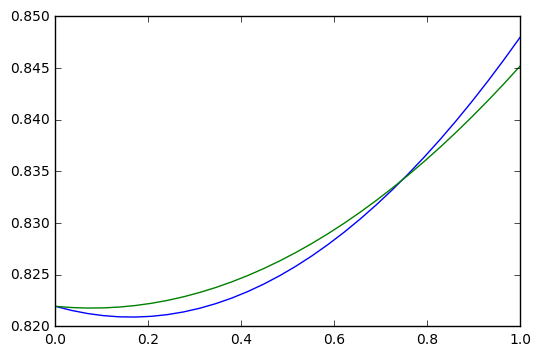

In [1028]:
plt.plot(meanWeights, rmsesSimpleManyRatings)
plt.plot(meanWeights, rmsesFacManyRatings)

In [634]:
print meanWeights[np.argmin(rmsesSimpleManyRatings)]
print rmsesSimpleManyRatings[np.argmin(rmsesSimpleManyRatings)]

0.448275862069
0.910841787756


In [ ]:
0.448275862069
0.910841787756
In [ ]:
In [ ]:
In [ ]:
In [ ]:


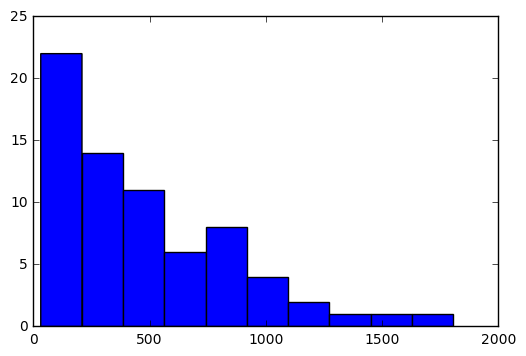

In [636]:
numRatingsByComm = glRatingsTrainWithComm.groupby(['comm'], {'numRatings': gl.aggregate.COUNT('rating')})
plt.hist(numRatingsByComm['numRatings']);

In [637]:
pdRatingsTrain = glRatingsTrainWithComm.to_dataframe()
pdRatingsTest = glRatingsTestWithComm.to_dataframe()

In [639]:
numRatingsByCommDict = defaultdict(int, {r['comm']: r['numRatings'] for r in numRatingsByComm})

In [640]:
pdRatingsTest['numRatingsByComm'] = pdRatingsTest['comm'].apply(lambda x: numRatingsByCommDict[x])

In [641]:
pdRatingsTest['numRatingsByComm'].describe()

count    15168.000000
mean       767.916930
std        472.438757
min          0.000000
25%        400.000000
50%        751.000000
75%       1180.000000
max       1806.000000
Name: numRatingsByComm, dtype: float64

In [657]:
numRatingsCutoff = 1180
pdManyRatings = pdRatingsTest[(pdRatingsTest['numRatingsByComm'] > numRatingsCutoff) & (pdRatingsTest['numRatingsByComm'] > 0)]
print ((pdRatingsTest['numRatingsByComm'] > numRatingsCutoff) * (pdRatingsTest['numRatingsByComm'] > 0)).mean()

0.165545886076


In [658]:
pdManyRatings.shape

(2511, 5)

In [659]:
meanWeights = np.linspace(0,1,30)

rmsesSimpleManyRatings = []
for weight in meanWeights:
    rmsesSimpleManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, False, False, weight)[1])
    
rmsesFacManyRatings = []
for weight in meanWeights:
    rmsesFacManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, True, False, weight)[1])

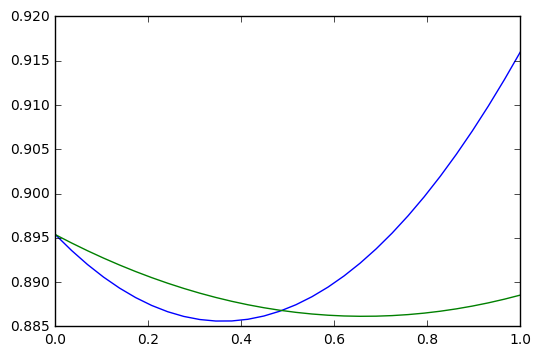

In [660]:
plt.plot(meanWeights, rmsesSimpleManyRatings)
plt.plot(meanWeights, rmsesFacManyRatings)

In [661]:
print meanWeights[np.argmin(rmsesSimpleManyRatings)]
print rmsesSimpleManyRatings[np.argmin(rmsesSimpleManyRatings)]

0.344827586207
0.885610939914


In [ ]:
0.448275862069
0.945779144527
In [ ]:
In [ ]:
In [ ]:
In [ ]:
In [ ]:
